In [1]:
#!/usr/bin/env python
# coding: utf-8

# gradient descent reblancer v1.1.py -
#

# To do
#   Filling gaps in input data - Abandoned
#     Only when market is opened?
#     second to 00:00:00 format
#     display count in each bea in histogram
#   Feeding only nomral gap data to analysis

# Reference:
#   Add info in plot https://queirozf.com/entries/add-labels-and-text-to-matplotlib-plots-annotation-examples
#   Format https://www.w3schools.com/python/ref_string_format.asp
#

In [2]:
import json, os, pdb, sys
import statistics
import requests
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pkl
import tensorflow as tf
# import matplotlib.pyplot as plt

In [3]:
import os
import pandas as pd



TSLAdata=pd.read_csv("TSLA_2020_2020.txt",delimiter="\,")
TSLAdata.columns = ["timestamp", "open", "high", "low", "close", "volume"]
#TSLAdata

/home/cloud/anaconda3/envs/grad/lib/python3.7/site-packages/ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [4]:
EARLY_DEBUGGING = False
DEBUGGING = True
TESTING = True

FILLING = True  # Fill the gap in time
PLOT = True
VALUE_DISP = True  # Value on plot?
JUPYTER_NOTEBOOK = False  # Greph shown in Jupyter Notebook


if (JUPYTER_NOTEBOOK):
    %matplotlib inline

In [5]:
# Input argument
# Instead of command argument, Jupyter Notebook
given_args = {
    'in_file': "TSLA_2020_2020.txt",
    'out_file': "gap.pkl"
}

In [6]:
# GLOBAL

tickers = ["TSLA"]
mins_ago_to_fetch = 100000  # see also filter_history_by_date()
ticker_history = {}
hist_length = 0
average_returns = {}
cumulative_returns = {}
gap_limit_lower = 60 * 10**9  # unit is nano second, will be adjusted
gap_limit_upper = 1600 * 10**9  # unit is nano second, will be adjusted
selected_year = 2016
label_text = list()


def fetch_all():
  for ticker in tickers:
    ticker_history[ticker] = fetch_history(ticker)

def fetch_history(ticker):
  hist = pd.read_csv("TSLA_2020_2020.txt",delimiter="\,")
  hist.columns = ["timestamp", "Open", "High", "Low", "Close", "Volume"]
  #hist = TSLAdata
  hist = index_history(hist)
  hist = filter_history_by_date(hist)
  return hist

def index_history(hist):
  # index by date so we can easily filter by a given timeframe
  hist = hist.set_index('timestamp')
  hist.index = pd.to_datetime(hist.index, unit='ns')
  return hist

def filter_history_by_date(hist):
  result = hist[hist.index.year >= selected_year]
  # result = result[result.index.day == 1] # every first of month, etc.
  return result


# ===== ===== ===== ===== ===== ===== =====
# There is some non value in given data, so we will see how many
inside_data = dict()

fetch_all()

# ----- ----- ----- ----- ----- ----- -----
# To do
# Filling gaps in input data
# (1) Calculate timestamp gap
# (2) if gap is between lower and upper limits, add fabricated time stamp and value
#     value could be from linear, cubic or sinc (Lanczos3) interpolation,
#     super resolution
hist = ticker_history[tickers[0]]

hist_gap = pd.DataFrame(index=hist.index,
		columns=hist.columns)
hist_gap['gap'] = hist.index.to_series().diff()
for i in hist.columns:
     hist_gap[i] = hist[i].diff()

hist_length = len(ticker_history[tickers[0]])

/home/cloud/anaconda3/envs/grad/lib/python3.7/site-packages/ipykernel_launcher.py:20: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


In [7]:
# (Pdb) ticker_history['TSLA'].columns
# Index(['Open', 'High', 'Low', 'Close', 'Volume', 'return', 'excess_return'], dtype='object')
ticker_history['TSLA']

,Open,High,Low,Close,Volume
timestamp,,,,,
2020-01-02 04:03:00,422.07,422.50,422.07,422.50,928
2020-01-02 04:04:00,422.16,422.16,422.16,422.16,356
2020-01-02 04:07:00,423.00,423.00,423.00,423.00,201
2020-01-02 04:14:00,422.53,422.53,422.53,422.53,160
2020-01-02 04:24:00,422.20,422.20,422.20,422.20,196
...,...,...,...,...,...
2020-08-07 19:44:00,1449.99,1449.99,1449.99,1449.99,413
2020-08-07 19:45:00,1449.05,1449.05,1449.05,1449.05,1507
2020-08-07 19:51:00,1451.00,1451.00,1451.00,1451.00,415


In [8]:
#TSLAdata[‘close’].fillna(value=TSLAdata[‘Item_Weight’].mean(), inplace=True)


# ![alt text](https://cdn-images-1.medium.com/max/750/0*XcQBOZQBItuoaFKi)
#
# Daily return of an asset is the ratio between the price variation over the initial price.

# ![alt text](https://cdn-images-1.medium.com/max/750/0*_SHk9qM3JOSGKeNE)
#
# The excess return over a certain period is the difference between the average return and the actual return.

In [9]:
# Calculate returns and excess returns

def add_all_returns():
  for ticker in tickers:
    hist = ticker_history[ticker]
    hist['return'] = (hist['Close'] - hist['Open']) / hist['Open']
    average = hist["return"].mean()
    average_returns[ticker] = average
    cumulative_returns[ticker] = (hist["return"] + 1).prod() - 1
    hist['excess_return'] = hist['return'] - average
    ticker_history[ticker] = hist

add_all_returns()

# display data
cumulative_returns


# Several things just happened here:
#
# We added the return and excess_return columns to every row of our historic data frames
# We stored the average return of every asset
# We stored the cumulative return for every historic we have

# Now it’s time to combine the excess returns into the n × k Excess Return Matrix X, where n is the number of observations (days, weeks, months, …) and k is the number of assets in out portfolio.

# ![alt text](https://cdn-images-1.medium.com/max/1000/0*pGapNlxAygWJdwQt)

{'TSLA': -0.37056543719546275}

In [10]:
# Excess matrix

excess_matrix = np.zeros((hist_length, len(tickers)))

for i in range(0, hist_length):
  for idx, ticker in enumerate(tickers):
    excess_matrix[i][idx] = ticker_history[ticker].iloc[i]['excess_return']

In [11]:
# Excess matrix

excess_matrix = np.zeros((hist_length, len(tickers)))

for i in range(0, hist_length):
  for idx, ticker in enumerate(tickers):
    excess_matrix[i][idx] = ticker_history[ticker].iloc[i]['excess_return']


if (EARLY_DEBUGGING):
    pdb.set_trace()


# The first line creates an n × k matrix and the loops assign
# the corresponding values to each ticker.

Input data size: 106732
gap.pkl saved.


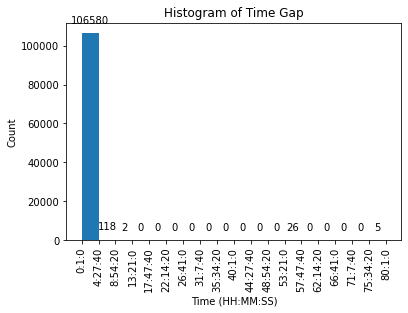

SystemExit: 1

In [14]:
# (Pdb) pretty_matrix
#                          TSLA
# timestamp
# 2020-01-02 04:03:00  0.001021
pretty_matrix = pd.DataFrame(excess_matrix).copy()
pretty_matrix.columns = tickers
pretty_matrix.index = ticker_history[tickers[0]].index

# pretty_matrix

if (EARLY_DEBUGGING):
    pdb.set_trace()

# ----- ----- ----- ----- ----- ----- ----- ----- ----- ---- ----- -----]

# Filling gaps in input data when gap is in market opened
# 60 second limt
# Added row: 220359
# Modified data size: 314877
# (1) Calculate timestamp gap
if (FILLING):

    if (TESTING):
        print ( "Input data size: {}".format(len(pretty_matrix)) )
        total_added = 0  # Count of row adding

    # (Pdb) pretty_matrix
    #                          TSLA
    # timestamp
    # 2020-01-02 04:03:00  0.001021
    pretty_matrix_filled = pd.DataFrame(columns=pretty_matrix.columns)

    # (Pdb) mask
    # timestamp
    # 2020-01-02 04:03:00        NaT
    # 2020-01-02 04:04:00   00:01:00
    mask = pretty_matrix.index.to_series().diff()  # <class 'pandas.core.series.Series'>

    # check how many non value in the given data
    for i in mask:
        if type(i) not in inside_data.keys():
            inside_data[type(i)] = 1
        else:
            inside_data[type(i)] += 1


    if (PLOT):  # Histogram of gap in time
        # First one is not a number
        # timedelta --> integer as second for historgram
        a_temp = temp = \
            [(np.timedelta64(i, 's')/np.timedelta64(1,'s')).astype(int)
            for i in mask[1:]]

        if (DEBUGGING):
            try:
                fileObject = open(given_args["out_file"], 'wb')
                pkl.dump(a_temp, fileObject)
                fileObject.close()
            except Exception as e:
                print (e.args)
                sys.exit(1)
            else:
                print ("{} saved.".format(given_args["out_file"]))

        # Draw the figure to get the current axes text
        fig, ax = plt.subplots()
        # arguments are passed to np.histogram
        n, bins, patches = plt.hist(a_temp, bins='auto')
        plt.title("Histogram of Time Gap")

        plt.draw()

        if (EARLY_DEBUGGING):
            pdb.set_trace()

        ax.set_xticks(bins)
        # Edit the text to your liking
        for loc in bins:
            a = loc % 60
            b = loc/60 % 60
            c = loc/60/60
            label_text.append( "{}:{}:{}".format(int(c), int(b), int(a)) )

        ax.set_xticklabels(label_text)# the histogram of the data
        plt.xticks(rotation=90)
        plt.xlabel('Time (HH:MM:SS)')
        plt.ylabel('Count')

        # To do
        #   second to 00:00:00 format
        #   display count in each bea in histogram


        if (VALUE_DISP):
            bins_center = [ ((bins[i_dx] + bins[i_dx + 1]) / 2.0)
                for i_dx in range(len(bins) - 1)]
            # zip joins x and y coordinates in pairs
            for x,y in zip(bins_center, n):

                label = "{}".format(int(y))

                plt.annotate(label, # this is the text
                             (x,y), # this is the point to label
                             textcoords="offset points", # how to position the text
                             xytext=(0,10), # distance from text to points (x,y)
                             ha='center') # horizontal alignment can be left, right or center

        plt.show()


    # (2) if gap is larger than limit, add fabricated time stamp and value
    #     value could be from linear, cubic or sinc (Lanczos3) interpolation,
    #     super resolution
    # integer in second ---> TimeDelta in Nano second
    # The first time gap is normal
    # after then it should be filled but not after market period
    gap_limit_lower = pd.to_timedelta(bins[0], unit='s')
    gap_limit_upper = pd.to_timedelta(bins[1], unit='s')

    if (DEBUGGING):
        sys.exit(1)
        pdb.set_trace()

    for i_dx, i in enumerate(pretty_matrix.index):
        if (i_dx != 0) and (mask.iloc[i_dx] > gap_limit_lower and
            mask.iloc[i_dx] <= gap_limit_upper):
            # Linear
            # Value difference between gap
            difference = \
                pretty_matrix.iloc[i_dx, 0] - pretty_matrix.iloc[i_dx - 1, 0]
            # Increase of value in each insertion
            increase = difference / int(mask.iloc[i_dx] / gap_limit_upper)
            # Time difference between gap
            difference_name = \
                pretty_matrix.index[i_dx] - pretty_matrix.index[i_dx - 1]
            # Increase of time in each insertion
            increase_name = difference_name / int(mask.iloc[i_dx] / gap_limit_upper)
            for j in range(int(mask.iloc[i_dx] / gap_limit_upper)):
                cur_val = pretty_matrix.iloc[i_dx, 0] + j * increase
                cur_name = pretty_matrix.index[i_dx] + j * increase_name
                cur = pd.Series(data={pretty_matrix.columns[0]: cur_val},
                    name=cur_name)
                pretty_matrix_filled = \
                    pretty_matrix_filled.append(
                    cur, ignore_index=False)

                if (TESTING):
                    total_added += 1
                    print ("Added row: {}".format(total_added))
        else:
            cur = pretty_matrix.iloc[i_dx]
            pretty_matrix_filled = \
                pretty_matrix_filled.append(cur, ignore_index=False)

    pretty_matrix_original = pretty_matrix
    pretty_matrix = pretty_matrix_filled

    if (TESTING):
        pdb.set_trace()
        print ( "Modified data size: {}".format(len(pretty_matrix_filled)) )

# ![alt text](https://cdn-images-1.medium.com/max/800/0*MKgTBXtRYApe1ycw)

# **Risk Modeling**
#
# There are many approaches that can be used to optimize a portfolio.
# In the present article we will analyze the variance and covariance of
# individual assets in order to minimize the global risk.
#
# To this end, we will use our Excess Return Matrix
# to compute the Variance-covariance Matrix Σ from it.

In [ ]:
# Variance co-variance matrix
# product_matrix will be one value
product_matrix = np.matmul(excess_matrix.transpose(), excess_matrix)
var_covar_matrix = product_matrix / hist_length

In [ ]:
pretty_matrix = pd.DataFrame(var_covar_matrix).copy()
pretty_matrix.columns = tickers
pretty_matrix.index = tickers

if (DEBUGGING):
    pdb.set_trace()


# ![alt text](https://cdn-images-1.medium.com/max/800/0*00nkyzYnQm3T28xN)

# cov x, y is the covariance between asset X and asset Y
#
# When x = y the value is the variance of the asset

# Before we can jump into the actual portfolio optimization,
# our next target is the Correlation Matrix, where every item is defined like:

# ![alt text](https://cdn-images-1.medium.com/max/600/0*iPVjT37R1LW6FMZp)

# The correlation between assets X and Y is their covariance divided by
# the product of their standard deviations.
#
# We already have cov(X, Y) stored in var_covar_matrix so we need a k × k matrix with the products of each standard deviation.
#
# Let’s compute the individual standard deviations:

In [ ]:
# Standard Deviation

std_deviations = np.zeros((len(tickers), 1))

for idx, ticker in enumerate(tickers):
  std_deviations[idx][0] = np.std(ticker_history[ticker]['return'])

In [ ]:
pretty_matrix = pd.DataFrame(std_deviations).copy()
pretty_matrix.columns = ['Std Dev']
pretty_matrix.index = tickers

if (EARLY_DEBUGGING):
    pretty_matrix


# To generate the matrix with the standard deviation products,
# we multiply the above by its transpose.

In [ ]:
# Std Deviation products matrix

sdev_product_matrix = np.matmul(std_deviations, std_deviations.transpose())

In [ ]:
pretty_matrix = pd.DataFrame(sdev_product_matrix).copy()
pretty_matrix.columns = tickers
pretty_matrix.index = tickers

if (EARLY_DEBUGGING):
    pretty_matrix


# NameError: name 'correlation_matrix' is not defined

In [ ]:
# Correlation matrix

correlation_matrix = var_covar_matrix / sdev_product_matrix

In [ ]:
# Optimize weights to minimize variance

def minimize_volatility():

  # Define the model
  # Portfolio Volatility = Sqrt (Transpose (Wt.SD) * Correlation Matrix * Wt. SD)

  if (DEBUGGING):
     pdb.set_trace()

  ticker_weights = tf.Variable(np.full((len(tickers), 1), 1.0 / len(tickers))) # our variables
  weighted_std_devs = tf.multiply(ticker_weights, std_deviations)

  product_1 = tf.transpose(weighted_std_devs)
  product_2 = tf.matmul(product_1, correlation_matrix)

  portfolio_variance = tf.matmul(product_2, weighted_std_devs)
  portfolio_volatility = tf.sqrt(tf.reduce_sum(portfolio_variance))

  # Run
  learn_rate = 0.01
  steps = 5000

  init = tf.global_variables_initializer()

  # Training using Gradient Descent to minimize variance
  train_step = tf.train.GradientDescentOptimizer(learn_rate).minimize(portfolio_volatility)

  with tf.Session() as sess:
    sess.run(init)
    for i in range(steps):
      sess.run(train_step)
      if i % 1000 == 0 :
        print("[round {:d}]".format(i))
        print("Weights", ticker_weights.eval())
        print("Volatility: {:.2f}%".format(portfolio_volatility.eval() * 100))
        print("")

    return ticker_weights.eval()

weights = minimize_volatility()

pretty_weights = pd.DataFrame(weights * 100, index = tickers, columns = ["Weight %"])

if (EARLY_DEBUGGING):
    pretty_weights


# So now, we can finally compute the Correlation Matrix, as we defined before.

In [ ]:
pretty_matrix = pd.DataFrame(correlation_matrix).copy()
pretty_matrix.columns = tickers
pretty_matrix.index = tickers

if (EARLY_DEBUGGING):
    pretty_matrix


# In the Correlation Matrix:
#
# The correlation of an asset’s returns with itself is always 1
#
# Correlation values range from –1 to 1
#
# Values tending to 1 mean that two random variables tend to have linear relationship
#
# Correlation values tending to –1 (anticorrelation) mean that two assets tend to have opposite behaviors
#
# Correlation values of 0 mean that two random variables are independent

# **Portfolio optimization**
#
# Given the average return and the variance of our assets, now it’s time to decide how much money is allocated in each one.
#
# At this point, we would like to find a combination of investments that minimizes the global variance of the portfolio.

# ![alt text](https://cdn-images-1.medium.com/max/600/0*T-7HtN5qlYnlU1ay)

# The weights array is the output we aim to get from our portfolio optimizer. The weight of every asset can range from 0 to 1, and the overall sum must be 1.

# Given the weights array, we can define the weighted standard deviation as:
#
# ![alt text](https://cdn-images-1.medium.com/max/800/0*3hUQbQITXFV8ARY0)

# So the global variance of our portfolio can now be defined as:
#
# ![alt text](https://cdn-images-1.medium.com/max/800/0*liHv3gq7jchT_9BZ)
#
# Where W is a 1 × k matrix with the weighted standard deviations , C is the Correlation Matrix described above and the result is a 1 × 1 matrix with the global portfolio variance.
#
# This is the value that we want to minimize, but how can we do it?
# We could define functions that computed the global variance for given weight arrays, explore all the possible candidates and rate them.
#
# However, finding the absolute minimal value for an equation with k variables is an NP problem. The amount of calculations would grow exponentially with k if we attempted to evaluate every possible solution. Waiting 10³⁰ centuries to get an answer doesn’t look like an appealing scenario, does it?
#
# So the best alternative in our hands is to use Machine Learning to explore a diverse subset of the search space for us, and let it explore variants of branches with potential to perform better than their siblings.

# **Optimize weights using Tensorflow**

In [ ]:
# Optimize weights to minimize variance

def minimize_volatility():

  # Define the model
  # Portfolio Volatility = Sqrt (Transpose (Wt.SD) * Correlation Matrix * Wt. SD)

  ticker_weights = tf.Variable(np.full((len(tickers), 1), 1.0 / len(tickers))) # our variables
  weighted_std_devs = tf.multiply(ticker_weights, std_deviations)

  product_1 = tf.transpose(weighted_std_devs)
  product_2 = tf.matmul(product_1, correlation_matrix)

  portfolio_variance = tf.matmul(product_2, weighted_std_devs)
  portfolio_volatility = tf.sqrt(tf.reduce_sum(portfolio_variance))

  # Constraints: sum([0..1, 0..1, ...]) = 1

  lower_than_zero = tf.greater( np.float64(0), ticker_weights )
  zero_minimum_op = ticker_weights.assign( tf.where (lower_than_zero, tf.zeros_like(ticker_weights), ticker_weights) )

  greater_than_one = tf.greater( ticker_weights, np.float64(1) )
  unity_max_op = ticker_weights.assign( tf.where (greater_than_one, tf.ones_like(ticker_weights), ticker_weights) )

  result_sum = tf.reduce_sum(ticker_weights)
  unity_sum_op = ticker_weights.assign(tf.divide(ticker_weights, result_sum))

  constraints_op = tf.group(zero_minimum_op, unity_max_op, unity_sum_op)

  # Run
  learning_rate = 0.01
  steps = 5000

  init = tf.global_variables_initializer()

  # Training using Gradient Descent to minimize variance
  optimize_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(portfolio_volatility)

  with tf.Session() as sess:
    sess.run(init)
    for i in range(steps):
      sess.run(optimize_op)
      sess.run(constraints_op)
      if i % 2500 == 0 :
        print("[round {:d}]".format(i))
        print("Weights", ticker_weights.eval())
        print("Volatility: {:.2f}%".format(portfolio_volatility.eval() * 100))
        print("")

    sess.run(constraints_op)
    return ticker_weights.eval()

weights = minimize_volatility()

pretty_weights = pd.DataFrame(weights * 100, index = tickers, columns = ["Weight %"])

if (EARLY_DEBUGGING):
    pretty_weights

In [ ]:
# Optimize weights to maximize return/risk

import time
start = time.time()

def maximize_sharpe_ratio():

  # Define the model

  # 1) Variance

  ticker_weights = tf.Variable(tf.random_uniform((len(tickers), 1), dtype=tf.float64)) # our variables
  weighted_std_devs = tf.multiply(ticker_weights, std_deviations)

  product_1 = tf.transpose(weighted_std_devs)
  product_2 = tf.matmul(product_1, correlation_matrix)

  portfolio_variance = tf.matmul(product_2, weighted_std_devs)
  portfolio_volatility = tf.sqrt(tf.reduce_sum(portfolio_variance))


  # 2) Return

  returns = np.full((len(tickers), 1), 0.0) # same as ticker_weights
  for ticker_idx in range(0, len(tickers)):
    returns[ticker_idx] = cumulative_returns[tickers[ticker_idx]]

  portfolio_return = tf.reduce_sum(tf.multiply(ticker_weights, returns))

  # 3) Return / Risk

  sharpe_ratio = tf.divide(portfolio_return, portfolio_volatility)

  # Constraints

  # all values positive, with unity sum
  weights_sum = tf.reduce_sum(ticker_weights)
  constraints_op = ticker_weights.assign(tf.divide(tf.abs(ticker_weights), tf.abs(weights_sum) ))

  # Run
  learning_rate = 0.0001
  learning_rate = 0.0015
  steps = 10000

  # Training using Gradient Descent to minimize cost

  optimize_op = tf.train.GradientDescentOptimizer(learning_rate, use_locking=True).minimize(tf.negative(sharpe_ratio))
  #2# optimize_op = tf.train.AdamOptimizer(learning_rate, use_locking=True).minimize(tf.negative(sharpe_ratio))
  #3# optimize_op = tf.train.AdamOptimizer(learning_rate=0.00005, beta1=0.9, beta2=0.999, epsilon=1e-08, use_locking=False).minimize(tf.negative(sharpe_ratio))
  #4# optimize_op = tf.train.AdagradOptimizer(learning_rate=0.01, initial_accumulator_value=0.1, use_locking=False).minimize(tf.negative(sharpe_ratio))


  init = tf.global_variables_initializer()

  with tf.Session() as sess:
    ratios = np.zeros(steps)
    returns = np.zeros(steps)
    sess.run(init)
    for i in range(steps):
      sess.run(optimize_op)
      sess.run(constraints_op)
      ratios[i] = sess.run(sharpe_ratio)
      returns[i] = sess.run(portfolio_return) * 100
      if i % 2000 == 0 :
        sess.run(constraints_op)
        print("[round {:d}]".format(i))
        #print("Ticker weights", sess.run(ticker_weights))
        print("Volatility {:.2f} %".format(sess.run(portfolio_volatility)))
        print("Return {:.2f} %".format(sess.run(portfolio_return)*100))
        print("Sharpe ratio", sess.run(sharpe_ratio))
        print("")

    sess.run(constraints_op)
    # print("Ticker weights", sess.run(ticker_weights))
    print("Volatility {:.2f} %".format(sess.run(portfolio_volatility)))
    print("Return {:.2f} %".format(sess.run(portfolio_return)*100))
    print("Sharpe ratio", sess.run(sharpe_ratio))
    return sess.run(ticker_weights)

weights = maximize_sharpe_ratio()

print("Took {:f}s to complete".format(time.time() - start))
pretty_weights = pd.DataFrame(weights * 100, index = tickers, columns = ["Weight %"])

if (EARLY_DEBUGGING):
    pretty_weights

In [ ]:
# PLOTTING

# import matplotlib.pyplot as plt

def line_plot(line1, label1=None, units='', title=''):
    fig, ax = plt.subplots(1, figsize=(16, 9))
    ax.plot(line1, label=label1, linewidth=2)
    ax.set_ylabel(units, fontsize=14)
    ax.set_title(title, fontsize=18)
    ax.legend(loc='best', fontsize=18)

def lines_plot(line1, line2, label1=None, label2=None, units='', title=''):
    fig, ax = plt.subplots(1, figsize=(16, 9))
    ax.plot(line1, label=label1, linewidth=2)
    ax.plot(line2, label=label2, linewidth=2)
    ax.set_ylabel(units, fontsize=14)
    ax.set_title(title, fontsize=18)
    ax.legend(loc='best', fontsize=18)